# Extracting alerts

In [1]:
import pickle
import pandas
import json
import pprint
import os
import os.path
import re
import numpy
import scipy.stats
import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
CONCEPTS = ["HR", "InvBPDias", "InvBPSys", "SpO2", "RRtotal"]

PATTERN = "Ichilov_MICU_....."
SUFFIX = "HR,SpO2,InvBPSys,InvBPDias,RRtotal-15:15-rnn-128-3-0.5"

DATA = "../data"
STAY_ALERTS = os.path.join(DATA, "stay_alerts-{}.pkl".format(SUFFIX))
ALERT_RECORDS = os.path.join(DATA, "alerts-{}.json".format(SUFFIX))


SOMESTAYS = os.path.join(DATA, "somestays")
LABELED_SOMESTAY_ALERTS = os.path.join(DATA, "labeled_somestay_alerts-{}.pkl".format(SUFFIX))

For comparison we also load stay tags.

In [22]:
STAY_TAGS = os.path.join(DATA, "stay_tags.pkl")
with open(STAY_TAGS, "rb") as f:
    stay_tags = pickle.load(f)

We average over a window and issue alerts if above the thresholds.

In [23]:
WINDOW = '15min'
NLL_THRESHOLD = 2

In [24]:
MAX_NLL = 5
MIN_NLL = -3

def cutoff(nll):
    """Cutoffs extreme NLL values for better presentation
    """
    shift = (MAX_NLL + MIN_NLL)/2
    scale = (MAX_NLL - MIN_NLL)/2
    return scale*numpy.tanh((nll - shift)/scale) + shift

We go over stays now and collect alerts caused by average NLL exceeding the threshold. 

In [9]:
stay_alerts = {}
for fname in sorted(os.listdir(DATA)):
    m = re.match("^.*({})-predict-{}\.pkl".format(PATTERN, SUFFIX), fname)
    if m:
        stay = m.group(1)
        with open(os.path.join(DATA, fname), "rb") as f:
            df = pickle.load(f)

        concepts = [c for c in CONCEPTS if c + "_mean" in set(df.columns)]
        avg_nll = None
        any_avail = None
        any_counts = None
        for c in concepts:
            avail = numpy.logical_not(numpy.isnan(df[c]))

            # Accumulate average perplexity
            c_nll = df[c + "_nll"].copy()
            c_nll[numpy.logical_not(avail)] = 0.
            c_counts = c_nll.copy()
            c_counts[:] = 0
            c_counts[avail] = 1
            if avg_nll is None:
                avg_nll = c_nll
                any_avail = avail
                any_counts = c_counts
            else:
                avg_nll += c_nll
                any_avail = numpy.logical_or(any_avail, avail)
                any_counts += c_counts
        avg_nll /= any_counts
        
        # Resample to the window size
        win_nll = cutoff(avg_nll[any_avail]).resample(WINDOW).mean()
        alerts = win_nll[win_nll >= NLL_THRESHOLD]
        
        # Extract alert records
        alert_records = [{'stay': stay,
                          'concept': 'nll', 
                          'time': str(time),
                          'model': SUFFIX,
                          'value': value} for time, value in alerts.items()]
        if alert_records:
            print("stay {}: {} alerts, {} tags".format(stay, len(alert_records), 
                                                       len(stay_tags[stay])
                                                       if stay in stay_tags 
                                                       else "no"))
            stay_alerts[stay] = alert_records

# Finally, we are ready to save alerts as pkl and json records.

with open(STAY_ALERTS, "wb") as f:
    pickle.dump(stay_alerts, f)

with open(ALERT_RECORDS, "w") as f:
    for alert_records in stay_alerts.values():
        for rec in alert_records:
            print(json.dumps(rec), file=f)

stay Ichilov_MICU_20002: 9 alerts, 3 tags
stay Ichilov_MICU_20004: 6 alerts, 2 tags
stay Ichilov_MICU_20005: 3 alerts, 7 tags
stay Ichilov_MICU_20006: 2 alerts, 17 tags
stay Ichilov_MICU_20007: 2 alerts, no tags
stay Ichilov_MICU_20008: 7 alerts, no tags
stay Ichilov_MICU_20009: 4 alerts, no tags
stay Ichilov_MICU_20010: 8 alerts, 6 tags
stay Ichilov_MICU_20011: 20 alerts, 5 tags
stay Ichilov_MICU_20012: 15 alerts, 9 tags
stay Ichilov_MICU_20013: 73 alerts, 67 tags
stay Ichilov_MICU_20014: 71 alerts, 31 tags
stay Ichilov_MICU_20015: 89 alerts, 49 tags
stay Ichilov_MICU_20016: 2 alerts, 11 tags
stay Ichilov_MICU_20017: 22 alerts, 21 tags
stay Ichilov_MICU_20018: 78 alerts, 134 tags
stay Ichilov_MICU_20019: 9 alerts, 3 tags
stay Ichilov_MICU_20020: 17 alerts, 8 tags
stay Ichilov_MICU_20021: 46 alerts, 122 tags
stay Ichilov_MICU_20023: 47 alerts, 5 tags
stay Ichilov_MICU_20025: 3 alerts, no tags
stay Ichilov_MICU_20026: 2 alerts, no tags
stay Ichilov_MICU_20027: 2 alerts, no tags
stay Ich

KeyboardInterrupt: 

A scatter plot of #alerts vs #tags shows how correlated things are. 

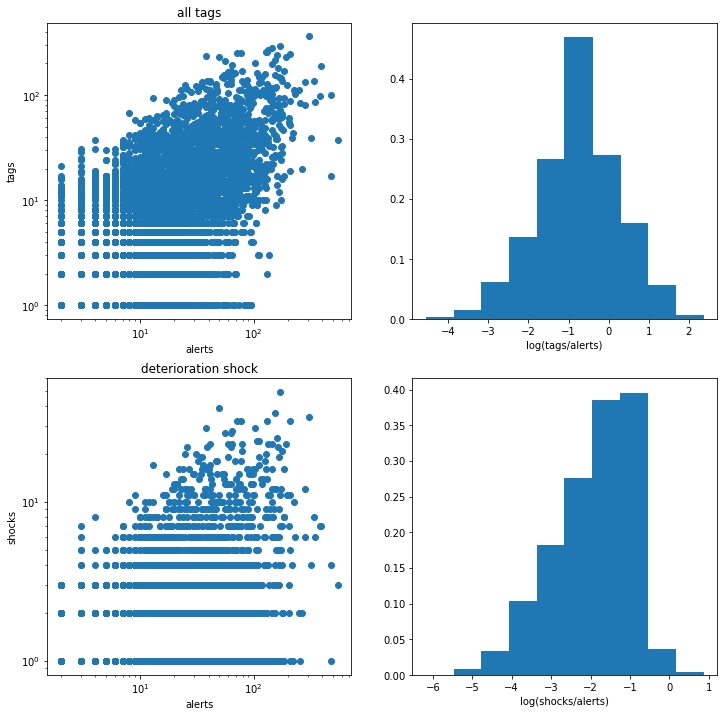

In [517]:
with open(STAY_ALERTS, "rb") as f:
    stay_alerts = pickle.load(f)

stays = stay_alerts.keys()
alert_counts = numpy.array([len(stay_alerts[stay]) for stay in stays])
tag_counts = numpy.array([len(stay_tags[stay]) if stay in stay_tags else 0 for stay in stays])
shock_counts = numpy.array([len([x for x in stay_tags[stay] if x['concept'] == 'deterioration_shock']) if stay in stay_tags else 0 for stay in stays])
fig, ax = plt.subplots(2, 2)
fig.set_figwidth(12)
fig.set_figheight(12)

ax[0][0].scatter(alert_counts + 1, tag_counts + 1)
ax[0][0].set_title("all tags")
ax[0][0].set_xlabel("alerts")
ax[0][0].set_ylabel("tags")
ax[0][0].set_xscale('log')
ax[0][0].set_yscale('log')
ax[0][1].hist(numpy.log((tag_counts + 1)/(alert_counts + 1)), edgecolor='tab:blue', normed=True)
ax[0][1].set_xlabel('log(tags/alerts)')

ax[1][0].scatter(alert_counts + 1, shock_counts + 1)
ax[1][0].set_title("deterioration shock")
ax[1][0].set_xlabel("alerts")
ax[1][0].set_ylabel("shocks")
ax[1][0].set_xscale('log')
ax[1][0].set_yscale('log')
ax[1][1].hist(numpy.log((shock_counts + 1)/(alert_counts + 1)), edgecolor='tab:blue', normed=True)
ax[1][1].set_xlabel('log(shocks/alerts)')

In [592]:
LOOKAHEAD = '12 hours'
LEADTIME = ['0 minutes', '30 minutes', '2 hours'][1]

def label_alerts(stays, lookahead=LOOKAHEAD, leadtime=LEADTIME):
    TP = 0
    FP = 0
    leads = []
    labeled_stay_alerts = {}
    for stayid in stays:
        if stayid in stay_tags:
            alert_times = sorted(set([alert['time'] for alert in stay_alerts[stayid]]))
            alerts = pandas.DataFrame({'time': alert_times, 'alert': [1] * len(alert_times)})
            alerts['time'] = pandas.to_datetime(alerts['time'])
            alerts = alerts.set_index('time')

            tag_times = sorted(set([tag['time'] for tag in stay_tags[stayid]]))
            tags = pandas.DataFrame({'time': tag_times, 'tag': [1] * len(tag_times)})
            tags['time'] = pandas.to_datetime(tags['time'])
            tags = tags.set_index('time')

            tag_alerts = pandas.concat([alerts, tags], axis=1)
            tag_alerts[numpy.isnan(tag_alerts)] = 0

            tag_alerts['calert'] = tag_alerts['alert'].cumsum()/tag_alerts['alert'].sum()
            tag_alerts['ctag'] = tag_alerts['tag'].cumsum()/tag_alerts['tag'].sum()

            labeled_stay_alerts[stayid] = []
            for i in range(len(tag_alerts)):
                if tag_alerts['alert'][i]:
                    j = i + 1
                    while True:
                        if j == len(tag_alerts):
                            label = 0
                            FP += 1
                            break
                        if tag_alerts.index[j] - tag_alerts.index[i] > pandas.Timedelta(lookahead):
                            FP += 1
                            label = 0
                            break
                        if tag_alerts.index[j] - tag_alerts.index[i] >= pandas.Timedelta(leadtime) and \
                           tag_alerts['tag'][j]:
                            label = 1
                            leads.append((tag_alerts.index[j] - tag_alerts.index[i]).seconds/3600)
                            TP += 1
                            break
                        j += 1
                    labeled_stay_alerts[stayid].append({
                        'stay': stayid,
                        'time': str(tag_alerts.index[i]),
                        'label': label})

            else:
                FP += len(alert_times)
            
    return TP, FP, labeled_stay_alerts, leads

In [593]:
TP, FP, labeled_stay_alerts, leads = label_alerts(list(stay_alerts.keys())[:100])
print(TP, FP)

642 3032


(array([ 103.,  103.,   87.,   86.,   67.,   50.,   44.,   46.,   31.,   25.]),
 array([  0.5 ,   1.65,   2.8 ,   3.95,   5.1 ,   6.25,   7.4 ,   8.55,
          9.7 ,  10.85,  12.  ]),
 <a list of 10 Patch objects>)

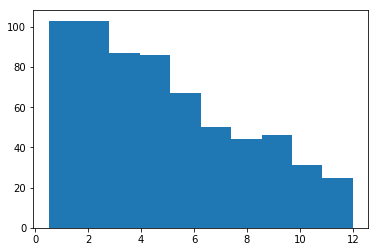

In [594]:
plt.hist(leads)

```
30 minutes - 12 hours
---------------------

model      | TP    | FP     | PPV
----------------------------------
rnn-128-3  | 41559 | 135224 | 0.235
grnn-128-3 | 40898 | 138789 | 0.228
rnn-256-4  | 27745 | 142274 | 0.163  #  not trained optimally?
```

Let's create a dataset for fiddling with data.

In [604]:
NSTAYS = 1000

Just some randomly chosen stays with alerts.

In [605]:
somestays = numpy.random.choice(list(stay_alerts.keys()), size=NSTAYS, replace=False)

Let's see how many alerts are there. 

In [612]:
TP, FP, labeled_somestay_alerts, someleads = label_alerts(somestays)
print("TP={}, FP={}".format(TP, FP))


TP=5955, FP=29677


In [616]:
with open(LABELED_SOMESTAY_ALERTS, "wb") as f:
    pickle.dump(labeled_somestay_alerts, f)

with open(SOMESTAYS, "w") as f:
    for s in somestays:
        print(s, file=f)